<a href="https://colab.research.google.com/github/AishaEvering/My_Assistant/blob/main/My_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

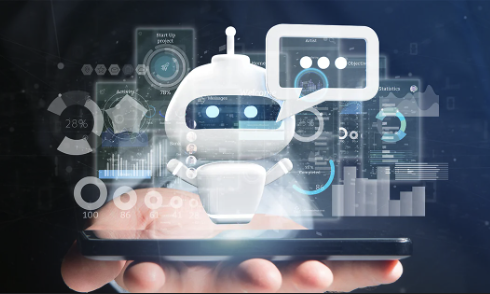

### Project Overview

In our fast-paced world, having a personal assistant can make life significantly easier. While some are fortunate enough to have one, most of us rely on virtual assistants like Alexa, Siri, Google Assistant, and now, My Assistant.

My Assistant is a fine-tuned DistilBERT model optimized for multiclass text classification. Trained on the [Bhuvaneshwari/intent_classification Hugging Face dataset](https://huggingface.co/datasets/Bhuvaneshwari/intent_classification) from Hugging Face, it accurately predicts customer intents across a range of categories, including:
- Add To Playlist
- Affirmation
- Book Meeting
- Book Restaurant
- Cancellation
- Excitment
- Get Weather
- Greetings
- Play Music
- Rate Book
- Search Creative Work
- Search Screening Event

The DistilBERT model was selected for its efficiency and speed. As a compact variant of the widely recognized BERT model, DistilBERT maintains the same maximum sequence length capability but offers enhanced performance by being faster and more resource-efficient.

### Key Objectives

**Develop and Train Neural Network Model**: Fine-tune a BERT transformer model using TensorFlow.
- **Handle Multi-Label Classification**: Implement techniques for multi-label classification to predict various intents.
- **Leverage a Diverse Dataset**: Utilize the [Bhuvaneshwari/intent_classification Hugging Face dataset](https://huggingface.co/datasets/Bhuvaneshwari/intent_classification) from Huggin Face to ensure a broad and representative range of comments.

### Project Details

1. **Dataset**: The [Bhuvaneshwari/intent_classification Hugging Face dataset](https://huggingface.co/datasets/Bhuvaneshwari/intent_classification)from Hugging Face offers a comprehensive collection of comments, categorized into 12 labels mentioned above.
   
2. **Task**: Develop a model to classify comments into multiple categories.

3. **Approach**:
  - **EDA**: Familiarize myself with the data and address any imbalances that may be present.
  - **Preprocess Data**: Tokenize the comments to convert them into features that the model can work with.
  - **Prepare Data and Model**: Set up training arguments, download DistilBERT, and configure a trainer.
  - **Model Training**: Train and optimize the neural network model for multi-class classification.
  - **Evaluation**: Assess the model's performance using appropriate multi-class metrics, including precision, recall, and accuracy.


# Import

In [1]:
!pip3 -qqq install pyarrow
!pip3 -qqq install datasets
!pip3 -qqq install tqdm
!pip3 -qqq install -U tensorflow==2.10

In [2]:
import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from sklearn.utils import resample
from nltk.corpus import stopwords
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm


In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
MODEL_NAME = 'distilbert-base-uncased'

# Load Data

In [5]:
ds = load_dataset('Bhuvaneshwari/intent_classification', split='train')
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['text', 'intent'],
    num_rows: 13808
})

In [6]:
df = ds.to_pandas()
df.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [7]:
df.shape

(13808, 2)

# Preprocess Data

## EDA

In [8]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [9]:
df.head()

,text,intent,count
0,listen to westbam alumb allergic on google music,PlayMusic,8
1,add step to me to the 50 clásicos playlist,AddToPlaylist,9
2,i give this current textbook a rating value of...,RateBook,16
3,play the song little robin redbreast,PlayMusic,6
4,please add iris dement to my playlist this is ...,AddToPlaylist,10


In [10]:
df['intent'].value_counts()

,count
intent,
PlayMusic,1914
GetWeather,1896
BookRestaurant,1881
RateBook,1876
SearchScreeningEvent,1852
SearchCreativeWork,1847
AddToPlaylist,1818
Cancellation,174
Affirmation,167


In [11]:
import re

def formatIntent(intent:str) -> str:
  return re.sub(r'([a-z])([A-Z])', r'\1 \2', intent)

In [12]:
df['intent'] = df['intent'].apply(lambda x: str.title(formatIntent(x)))
df['intent'].unique()

array(['Play Music', 'Add To Playlist', 'Rate Book', 'Greetings',
       'Search Screening Event', 'Book Restaurant', 'Get Weather',
       'Book Meeting', 'Search Creative Work', 'Cancellation',
       'Affirmation', 'Excitment'], dtype=object)

<Figure size 800x800 with 0 Axes>

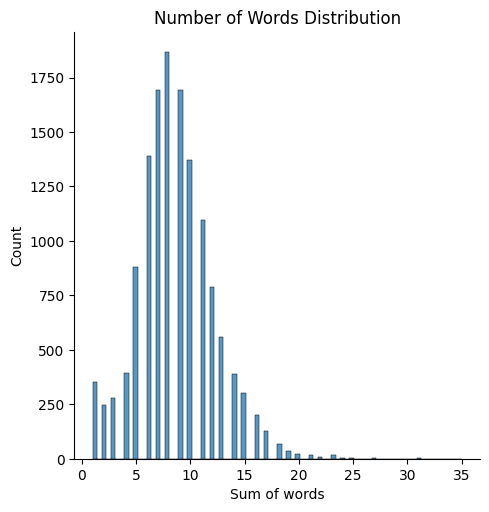

In [13]:
plt.figure(figsize = (8,8))

sns.displot(df['count'])

plt.xlabel('Sum of words')
plt.title('Number of Words Distribution')
plt.show()

Cool, the length of statement will not be a problem.  Distilled BERT has a maximum sequence length of 512 tokens.

In [14]:
intent_count = df['intent'].value_counts()
intents = intent_count.index
len(intents), intents

(12,
 Index(['Play Music', 'Get Weather', 'Book Restaurant', 'Rate Book',
        'Search Screening Event', 'Search Creative Work', 'Add To Playlist',
        'Cancellation', 'Affirmation', 'Excitment', 'Greetings',
        'Book Meeting'],
       dtype='object', name='intent'))

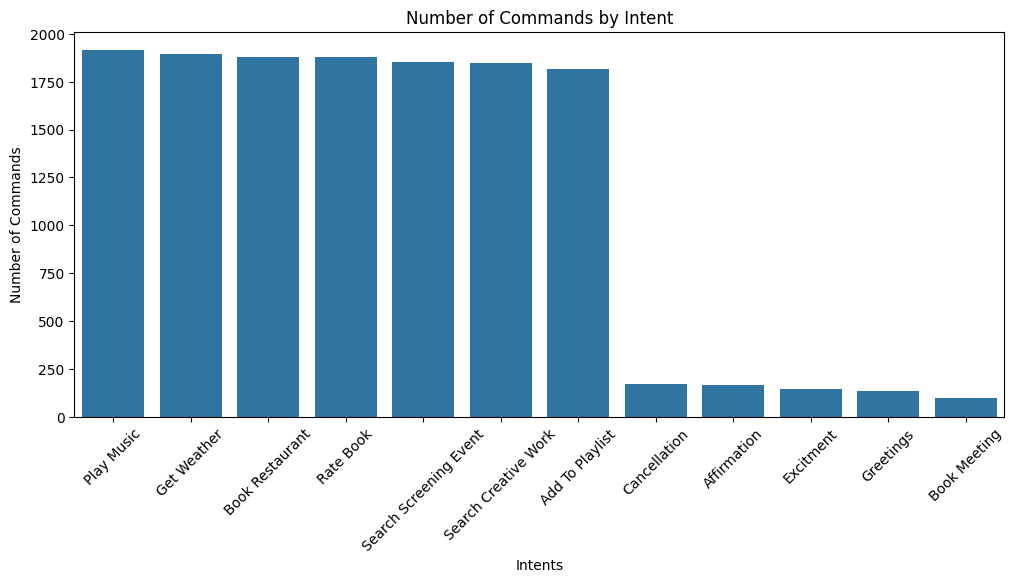

In [15]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = intent_count.index, y=intent_count)

plt.xlabel('Intents')
plt.ylabel('Number of Commands')
plt.xticks(rotation=45)
plt.title('Number of Commands by Intent')
plt.show()

The data is not balanced.  Let's try upsampling the minitory classes.

## Balancing Data

In [16]:
threshold = 250

intent_counts = df['intent'].value_counts()

majority_classes = intent_counts[intent_counts > threshold].index.tolist()
minority_classes = intent_counts[intent_counts <= threshold].index.tolist()

majority_classes, minority_classes

(['Play Music',
  'Get Weather',
  'Book Restaurant',
  'Rate Book',
  'Search Screening Event',
  'Search Creative Work',
  'Add To Playlist'],
 ['Cancellation', 'Affirmation', 'Excitment', 'Greetings', 'Book Meeting'])

In [17]:
# find the size of the largest class)
majority_size = df['intent'].value_counts().max()

# separate majority and minority classes
df_majority = df[df['intent'].isin(majority_classes)]
df_minority = df[df['intent'].isin(minority_classes)]

# upsample each minority class to match the size of the largest majority class
df_minority_upsampled = pd.concat([
    resample(df_minority[df_minority['intent'] == cls], replace=True,  n_samples=majority_size,  random_state=42)
    for cls in minority_classes
])

# combine majority and upsampled minority classes
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced.head()

,text,intent,count
0,play some gospel music,Play Music,4
1,book a meeting,Book Meeting,3
2,indeed,Affirmation,1
3,play track ai se eu te pego on google music fr...,Play Music,13
4,book a meeting,Book Meeting,3


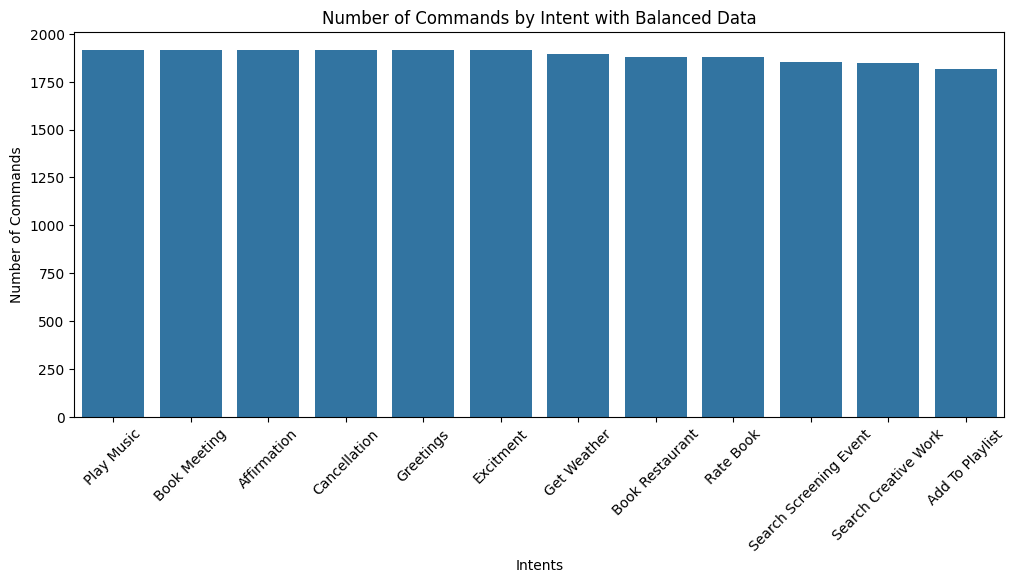

In [18]:
intent_count = df_balanced['intent'].value_counts()

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = intent_count.index, y=intent_count)

plt.xlabel('Intents')
plt.ylabel('Number of Commands')
plt.xticks(rotation=45)
plt.title('Number of Commands by Intent with Balanced Data')
plt.show()

Okay the data is balanced.  I may have to revisit this if I see significant overfitting when training the model.

In [19]:
df_balanced.shape

(22654, 3)

## Encodeing Categories

In [20]:
df_balanced['encoded_cat'] = df_balanced['intent'].astype('category').cat.codes
df_balanced.head()

,text,intent,count,encoded_cat
0,play some gospel music,Play Music,4,8
1,book a meeting,Book Meeting,3,2
2,indeed,Affirmation,1,1
3,play track ai se eu te pego on google music fr...,Play Music,13,8
4,book a meeting,Book Meeting,3,2


In [21]:
texts = df_balanced['text'].to_list()
labels = df_balanced['encoded_cat'].to_list()

# Prepare Data

## Split Data

In [22]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
print(f"train_texts: {len(train_texts)}, val_texts: {len(val_texts)}, train_labels: {len(train_labels)}, val_labels: {len(val_labels)}")

train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.1, random_state=42)
print(f"train_texts: {len(train_texts)}, test_texts: {len(test_texts)}, train_labels: {len(train_labels)}, test_labels: {len(test_labels)}")

train_texts: 18123, val_texts: 4531, train_labels: 18123, val_labels: 4531
train_texts: 16310, test_texts: 1813, train_labels: 16310, test_labels: 1813


## Tokenize Data and Create Datasets

Tokenize the features.

In [23]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Create datasets.

In [24]:

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings), val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

# Fine-tune Model

** warmup_steps**: is used to specify the number of training steps during which the learning rate will increase linearly from a small value to the initial learning rate. This gradual increase helps stabilize training and improve convergence by preventing the model from making large updates at the beginning of training.

In [25]:
from transformers import TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01, # prevents overfitting, by stopping it from fitting too closely to the training data
    logging_dir='./logs',
    eval_steps=100
)

## Create Model

In [26]:
from transformers import TFDistilBertForSequenceClassification

# Number of labels for classification
num_labels = len(df['intent'].unique())

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



tf_model.h5:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

## Train Model

In [28]:
from transformers import  TFTrainer

trainer = TFTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Evaluate Model

In [33]:
metrics = trainer.evaluate(test_dataset)
print(f"Test metrics: {metrics}")

Test metrics: {'eval_loss': 0.05307388716730578}


# Saving & Loading the model

In [36]:
import os

models_dir = 'saved_models'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

trainer.save_model(models_dir)
tokenizer.save_pretrained(models_dir)

('saved_models/tokenizer_config.json',
 'saved_models/special_tokens_map.json',
 'saved_models/vocab.txt',
 'saved_models/added_tokens.json',
 'saved_models/tokenizer.json')

## Loading Pre-Trained Model

In [37]:
tokenizer_fine_tuned = DistilBertTokenizerFast.from_pretrained(models_dir)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(models_dir)

Some layers from the model checkpoint at saved_models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Evaluate Mdoel

## Manual Test

In [38]:
test_text = test_texts[0]

test_text

'rate this novel four of 6'

In [ ]:
tokenizer_fine_tuned.encode()

In [41]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation = True,
    padding = True,
    return_tensors = "tf"
)

output = model_fine_tuned(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]

prediction_value

9

In [46]:
df_balanced.head()

,text,intent,count,encoded_cat
0,play some gospel music,Play Music,4,8
1,book a meeting,Book Meeting,3,2
2,indeed,Affirmation,1,1
3,play track ai se eu te pego on google music fr...,Play Music,13,8
4,book a meeting,Book Meeting,3,2


In [48]:
categories = df_balanced.groupby('intent')['encoded_cat'].first().reset_index()
categories

,intent,encoded_cat
0,Add To Playlist,0
1,Affirmation,1
2,Book Meeting,2
3,Book Restaurant,3
4,Cancellation,4
5,Excitment,5
6,Get Weather,6
7,Greetings,7
8,Play Music,8
9,Rate Book,9


## Evaluate on Test Dataset

In [62]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# predict on the test dataset
predictions = model_fine_tuned.predict(test_dataset)

logits = predictions.logits

predicted_labels = np.argmax(logits, axis=1)

# calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

1813/1813 [==============================] - 43s 23ms/step
Accuracy: 0.9889685603971319
Precision: 0.9892468103260361
Recall: 0.9892559646079316


Yes! This looks great!  Let's Deploy!

# Test On Gradio

In [63]:
!pip -qqq install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.9 MB/s eta 0:00:00


In [66]:
df_balanced.head()

,text,intent,count,encoded_cat
0,play some gospel music,Play Music,4,8
1,book a meeting,Book Meeting,3,2
2,indeed,Affirmation,1,1
3,play track ai se eu te pego on google music fr...,Play Music,13,8
4,book a meeting,Book Meeting,3,2


In [69]:
df_sorted = df_balanced.sort_values(by='encoded_cat')

unique_intents_sorted = df_sorted['intent'].unique().tolist()

print(len(unique_intents_sorted), unique_intents_sorted)

12 ['Add To Playlist', 'Affirmation', 'Book Meeting', 'Book Restaurant', 'Cancellation', 'Excitment', 'Get Weather', 'Greetings', 'Play Music', 'Rate Book', 'Search Creative Work', 'Search Screening Event']


In [70]:
from timeit import default_timer as timer

categories = ['Add To Playlist', 'Affirmation', 'Book Meeting', 'Book Restaurant',
              'Cancellation', 'Excitment', 'Get Weather', 'Greetings', 'Play Music',
              'Rate Book', 'Search Creative Work', 'Search Screening Event']

def predict(command:str):
  start_time = timer()

  predict_input = tokenizer_fine_tuned.encode(command, truncation = True,
                                              padding = True, return_tensors = "tf")

  output = model_fine_tuned(predict_input)[0]

  prediction_value = tf.argmax(output, axis=1).numpy()[0]

  pred_time = round(timer() - start_time, 4)

  return categories[prediction_value], pred_time

In [71]:
test_cmd = "Book reservations at Burger King."
predict(test_cmd)

('Book Restaurant', 0.1236)

In [79]:
df.sample(n=10)

,text,intent,count
6384,play music from 2007,Play Music,4
10764,i need a place that serves smelt for a party o...,Book Restaurant,15
2495,rate the current novel 5 of 6 points,Rate Book,8
1270,add five stars to my current chronicle,Rate Book,7
8177,what is the forecast for here and now,Get Weather,8
3221,what films are showing at century theatres,Search Screening Event,7
13489,cancel this,Cancellation,2
5168,play a martyn bennett from 1957 on pandora,Play Music,8
6699,book a table for 1 at a restaurant,Book Restaurant,8
7109,rate this textbook a 5,Rate Book,5


In [81]:
import gradio as gr

title = "My Assistant"
description = "A fine-tuned distilled BERT model designed to predict the intent of user commands."
article = "Created at [My Assistant](https://github.com/AishaEvering/My_Assistant)."
examples=["What is the forecast for here and now?", "What films are showing at century theatres?", "Book a table for 1 at a Burger King."]

interface = gr.Interface(fn=predict,
                         inputs=gr.Textbox(lines=2, placeholder="Give command here."),
                         outputs=['text', gr.Number(label="Prediction time (seconds)")],
                         title=title,
                         examples=examples,
                         description=description,
                         article=article)

In [82]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d6431dfc021d7df402.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Deploy to Hugging Face

In [84]:
import shutil
from pathlib import Path

demo_path = Path('demo/my_assistant/')

if demo_path.exists():
  shutil.rmtree(demo_path)

demo_path.mkdir(parents=True, exist_ok=True)

!ls demo/my_assistant

## Move Model to Demo Folder

In [85]:
model_path = '/content/saved_models'

model_destination = demo_path

try:
  print(f'[INFO] Attempting to mode {model_path} to {demo_path}')

  # Move the model
  shutil.move(src=model_path, dst=demo_path)

  print(f'[INFO] Model move complete.')
except:
  print(f'[INFO] No model found at {model_path}, perhaps its already been moved?')
  print(f'[INFO] Model exists at {demo_path} : {demo_path.exists()}')

[INFO] Attempting to mode /content/saved_models to demo/my_assistant
[INFO] Model move complete.


## Create app.py

In [87]:
%%writefile demo/my_assistant/app.py

import tensorflow as tf
import gradio as gr
from timeit import default_timer as timer

class_names = ['Add To Playlist', 'Affirmation', 'Book Meeting', 'Book Restaurant',
              'Cancellation', 'Excitment', 'Get Weather', 'Greetings', 'Play Music',
              'Rate Book', 'Search Creative Work', 'Search Screening Event']



# load tokenizer and model
MODEL_PATH = 'saved_models'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

# function to used to make predictions
def predict(command:str):
  start_time = timer()

  predict_input = tokenizer.encode(command, truncation = True, padding = True, return_tensors = "tf")

  output = model(predict_input)[0]

  prediction_value = tf.argmax(output, axis=1).numpy()[0]

  pred_time = round(timer() - start_time, 4)

  return class_names[prediction_value], pred_time


# create Gradio demo
title = "My Assistant"
description = "A fine-tuned distilled BERT model designed to predict the intent of user commands."
article = "Created at [My Assistant](https://github.com/AishaEvering/My_Assistant)."
examples=["What is the forecast for here and now?", "What films are showing at century theatres?", "Book a table for 1 at a Burger King."]

demo = gr.Interface(fn=predict,
                    inputs=gr.Textbox(lines=2, placeholder="Give command here."),
                    outputs=['text', gr.Number(label="Prediction time (seconds)")],
                    title=title,
                    examples=examples,
                    description=description,
                    article=article)

# Launch the demo!!!!
demo.launch(share=True)

Overwriting demo/my_assistant/app.py


## Create requirements.txt


In [88]:
%%writefile demo/my_assistant/requirements.txt
tensorflow==2.10
gradio==4.36.1

Writing demo/my_assistant/requirements.txt


## Zip Up Demo Folder

In [91]:
# Change into the demo directory and then zip it from the inside
!cd demo/my_assistant && zip -r ../my_assistant_demo.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

updating: app.py (deflated 50%)
updating: requirements.txt (stored 0%)
updating: saved_models/ (stored 0%)
updating: saved_models/config.json (deflated 57%)
updating: saved_models/tf_model.h5 (deflated 8%)
updating: saved_models/tokenizer_config.json (deflated 41%)
updating: saved_models/special_tokens_map.json (deflated 42%)
updating: saved_models/vocab.txt (deflated 53%)
updating: saved_models/tokenizer.json (deflated 71%)


## Download App Zip File

In [92]:
# Download
try:
  from google.colab import files
  files.download('demo/my_assistant_demo.zip')
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), \
  please download my_assistant_demo.zip manually.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>